In [62]:
#Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
from chart_studio import plotly
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [63]:
#Importing Data
listings = pd.read_csv("listings.csv", index_col= "id")
listings_details = pd.read_csv("listings_details.csv", index_col= "id", low_memory=False,encoding='latin-1')

calendar = pd.read_csv("calendar.csv", parse_dates=['date'], index_col=['listing_id'])
#reviews = pd.read_csv("../input/reviews.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("reviews_details.csv", parse_dates=['date']) #, index_col=['id'])

In [64]:
print(listings.shape)

(20030, 15)


In [65]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [66]:
#Checking Data types
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 2818 to 30580413
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            19992 non-null  object 
 1   host_id                         20030 non-null  int64  
 2   host_name                       20026 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   20030 non-null  object 
 5   latitude                        20030 non-null  float64
 6   longitude                       20030 non-null  float64
 7   room_type                       20030 non-null  object 
 8   price                           20030 non-null  int64  
 9   minimum_nights                  20030 non-null  int64  
 10  number_of_reviews               20030 non-null  int64  
 11  last_review                     17624 non-null  object 
 12  reviews_per_month         

In [67]:
listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,
2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,...,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,...,20,https://www.airbnb.com/rooms/3209,f,I am a freelance radio producer and journalist...,within an hour,100.0,"Amsterdam, Noord-Holland, Netherlands",$543.00,"$2,000.00",Amsterdam
20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,...,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within a few hours,100.0,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,...,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within a few hours,100.0,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150,2,171,...,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam


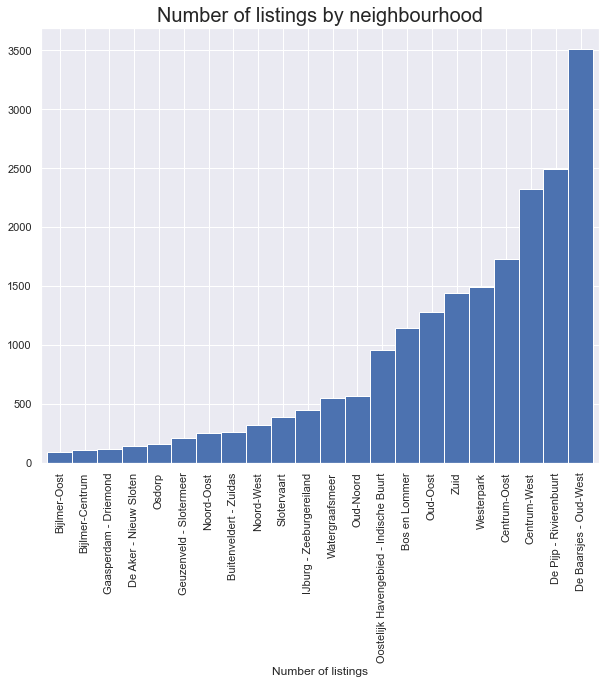

In [68]:
#Visualizing listings in a neighbourhood
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.bar(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

In [69]:
# Visualizing map of AirBnBs
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

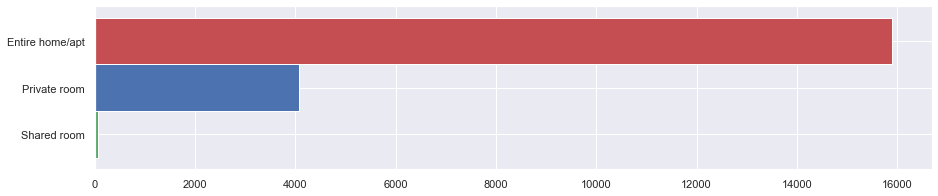

In [70]:
#Visualizing Comparison of types of AirBnBs
freq = listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"])
plt.show()

In [71]:
listings.property_type.unique()

array(['Apartment', 'Townhouse', 'Houseboat', 'Bed and breakfast', 'Boat',
       'Guest suite', 'Loft', 'Serviced apartment', 'House',
       'Boutique hotel', 'Guesthouse', 'Other', 'Condominium', 'Chalet',
       'Nature lodge', 'Tiny house', 'Hotel', 'Villa', 'Cabin',
       'Lighthouse', 'Bungalow', 'Hostel', 'Cottage', 'Tent',
       'Earth house', 'Campsite', 'Castle', 'Camper/RV', 'Barn',
       'Casa particular (Cuba)', 'Aparthotel'], dtype=object)

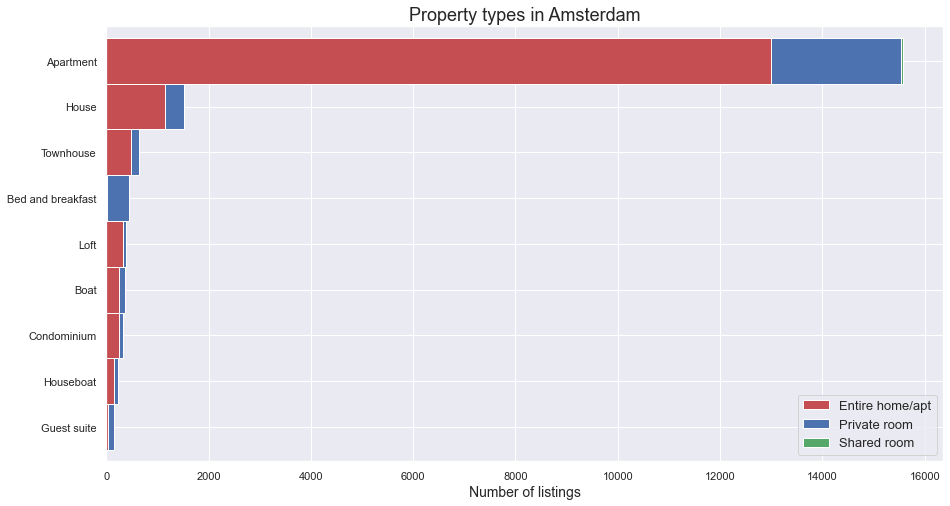

In [72]:
#Visualizing property types
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Amsterdam', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

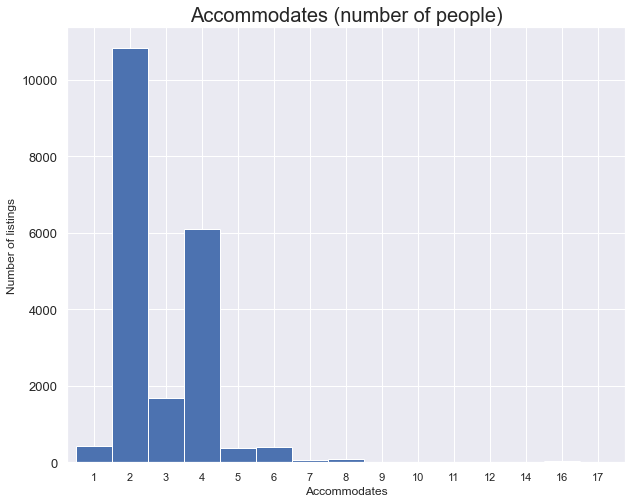

In [73]:
#Visualizing Accomodations
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

In [74]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'street']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,street,private_rooms
2436,67005410,Feliciano,"Amsterdam, Noord-Holland, Netherlands",15
918,10076897,Geraldine,"Amsterdam, Noord-Holland, Netherlands",13
2113,44168250,Ruben,"Amsterdam, Noord-Holland, Netherlands",13
1570,22879651,Wamme,"Amsterdam, Noord-Holland, Netherlands",7
3209,174174070,Amrath,"Badhoevedorp, Badhoevedorp, Netherlands",7


In [75]:
feliciano = private[private['host_id']== 67005410]
feliciano = feliciano[['name','host_id', 'host_name', 'latitude', 'longitude']]
feliciano.index.name = "listing_id"
feliciano

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
12392592,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.375251,4.900321
12444222,Hotel in the heart of Amsterdam 4p,67005410,Feliciano,52.375130,4.899694
12446710,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.374695,4.900266
12451293,"Hotel in the heart of Amsterdam, Single room",67005410,Feliciano,52.374682,4.898916
12579177,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.374567,4.898310
12582071,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.373407,4.900022
12865293,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.375077,4.900191
12865495,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.373396,4.898427
12898673,Hotel in the heart of Amsterdam 1p,67005410,Feliciano,52.373346,4.898344


In [76]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,...,19,21,24,25,27,30,38,83,105,208
count,15830,1104,174,50,37,24,9,6,4,3,...,2,2,1,1,1,1,1,1,1,1


In [77]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

,host_id,host_name,host_about,num_host_listings
8166,65859990,Martijn,"Hi, I'm Martijn, \r\n\r\nWe are a team of prof...",208
535,1464510,Michiel And Jane,"Hi, we are Michiel & Jane,\r\n\r\nWe are a tea...",105
8999,113977564,Willem,I own a hotel in Amsterdam and manage properti...,38
190,517215,Niels En Viv (Welcome Back),"Hi travellers, \r\n\r\nWe are Welcome Back, a ...",30
4935,14183886,Luis,We are Luis and Melanie and we managed our own...,25
4531,11969034,Raul,"Dear Guests,\r\n\r\nI'm Raul, 35 years old. I ...",24
7456,44168250,Ruben,Running a family business in real estate & tou...,21
3457,7594884,"Ruben, Sarah & Lindy","We are Ruben, Sarah & Lindy, we rent out prope...",21


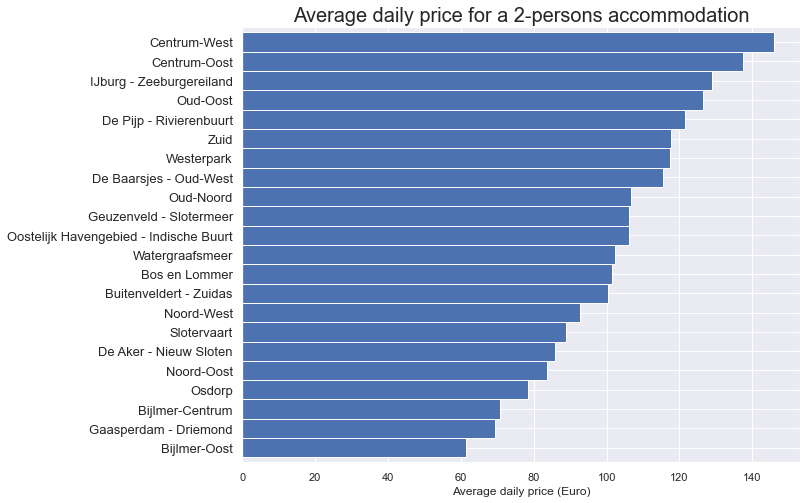

In [78]:
#Visualizing price
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()


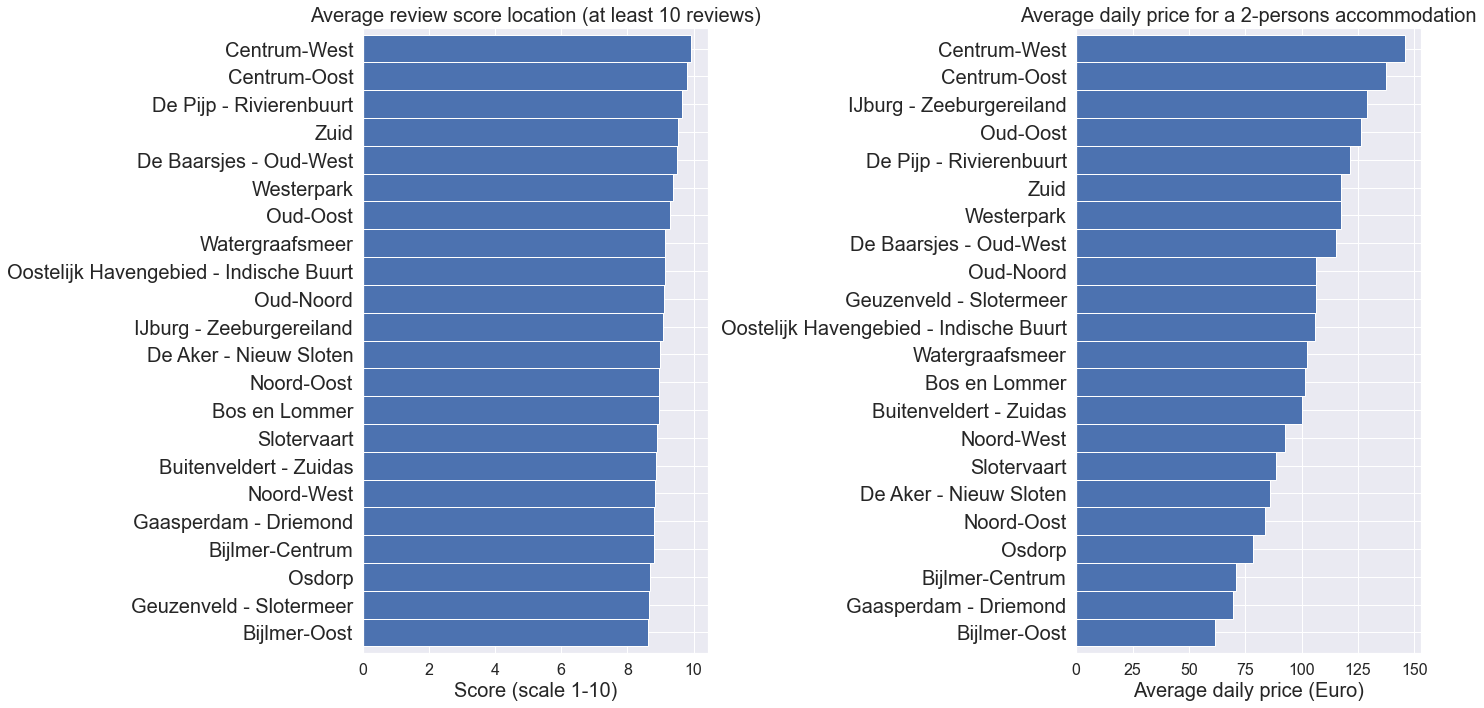

In [79]:
#Average review score 
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

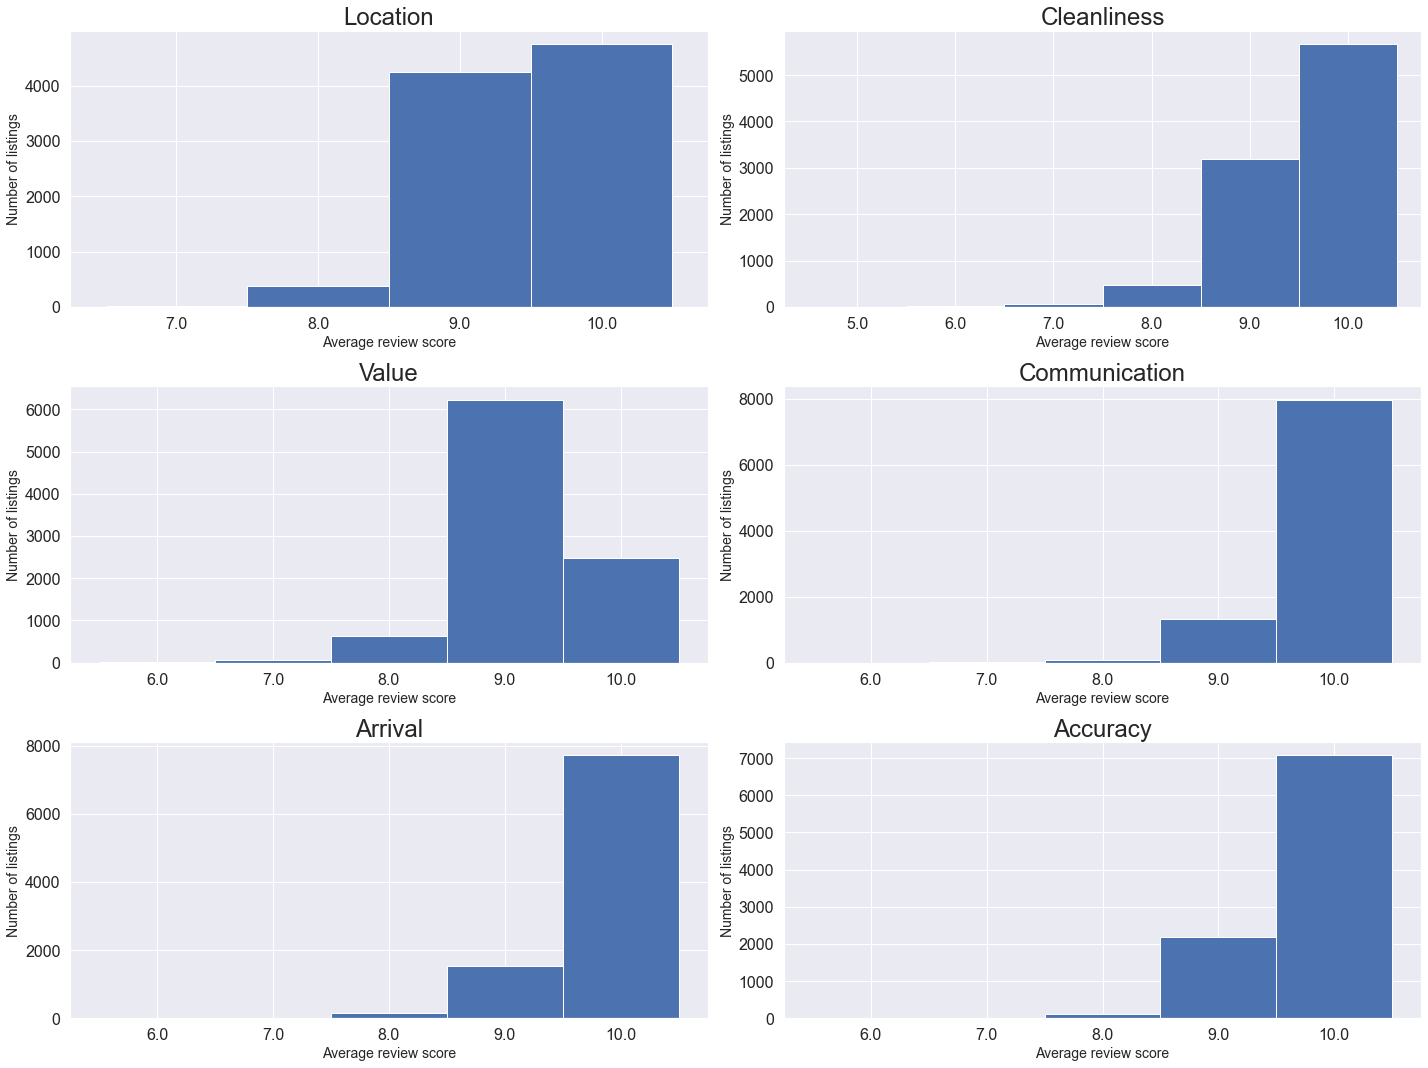

In [80]:
#Segmenting Reviews
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

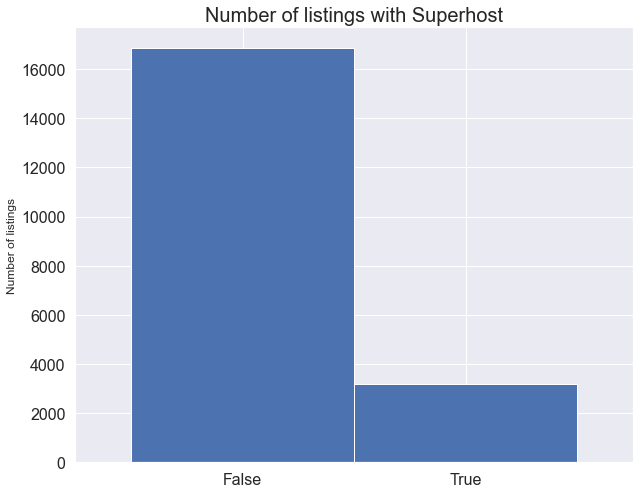

In [81]:
#Finding SuperHosts
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

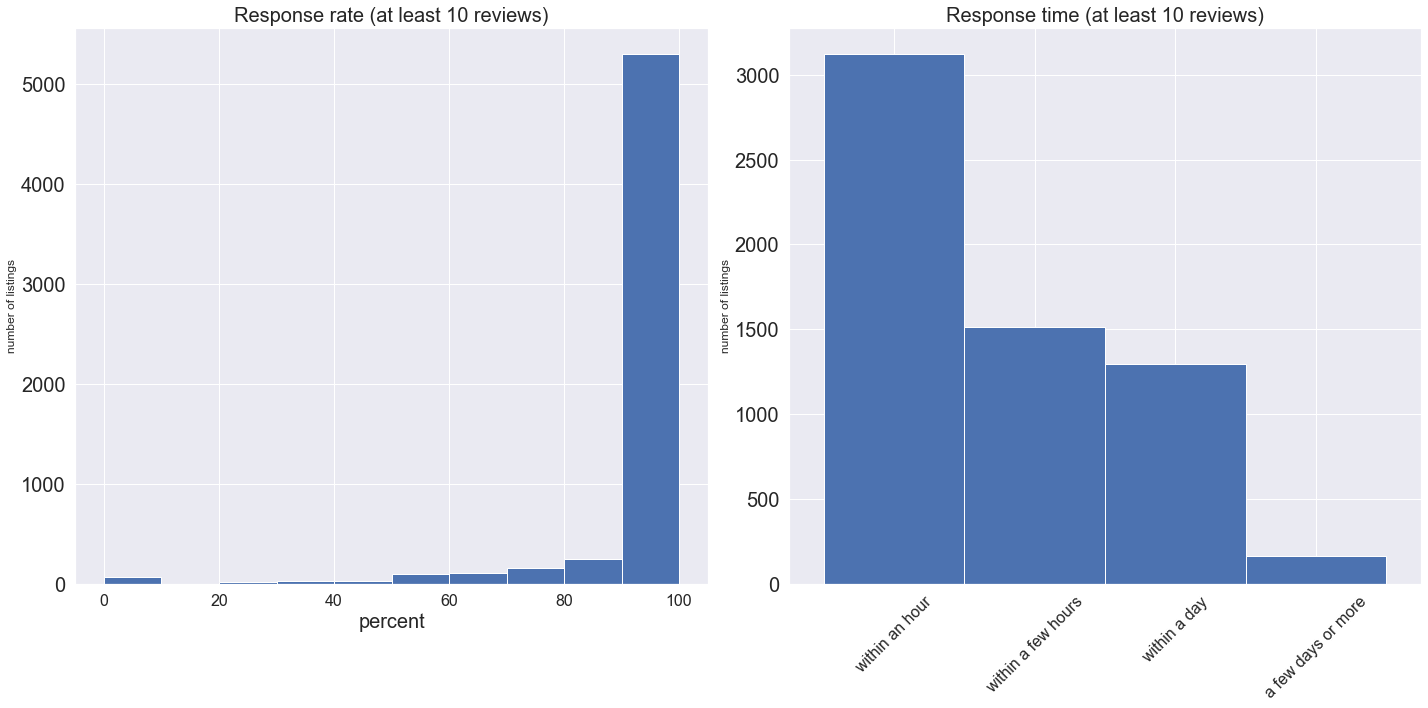

In [82]:
#Response Rate
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

In [83]:
#Cleaning calendar data
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2019-12-05']


In [84]:
print(calendar.shape)

(7290073, 3)


In [85]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,accommodates
listing_id,,,,
13972425,2019-09-26,f,NaN,2
4611207,2019-01-29,t,145.0,4
21562914,2018-12-06,f,NaN,4
7468232,2019-08-21,t,495.0,4
589237,2019-03-14,f,NaN,5
24748244,2019-11-14,f,NaN,2
15870679,2019-02-18,f,NaN,2
14115998,2019-01-20,f,NaN,2
3607787,2019-09-16,f,NaN,2


In [86]:
#Visualizing listings available
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date')

In [87]:
#Visualizing average price
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
    text='weekday', title='Average price of available 2 persons accommodation by date')

In [88]:
reviews_details.shape

(431830, 6)

In [89]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
1191,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1771,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
1989,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
2797,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
3151,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [90]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

,,number_of_reviews
host_id,host_name,
1464510,Michiel And Jane,1772
65859990,Martijn,1407
67005410,Feliciano,1350
336950,Manuel,1154
124245,Edwin,1001


In [91]:
reviews_details.comments.head()

id
1191    Daniel is really cool. The place was nice and ...
1771    Daniel is the most amazing host! His place is ...
1989    We had such a great time in Amsterdam. Daniel ...
2797    Very professional operation. Room is very clea...
3151    Daniel is highly recommended.  He provided all...
Name: comments, dtype: object

In [92]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

'We had such a great time in Amsterdam. Daniel is an excellent host! Very friendly and everytime helpful. The room was cozy, comfortable, and VERY clean. Maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. Bathroom with all the bathroom requires. Good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.\r\nTotally recommendable! '

In [93]:
import nltk
nltk.download('stopwords')
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

[nltk_data] Downloading package stopwords to C:\Users\Diksha
[nltk_data]     Nasa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


'great time amsterdam daniel excellent host friendly everytime helpful room cozy comfortable clean maps towels mini fridge coffee very tasty tea supplies provided bathroom bathroom requires good location next tram stop took around minutes get city center totally recommendable '

In [94]:
host_names = reviews_details[['host_name']].drop_duplicates()
host_names = host_names.host_name.str.lower().tolist()

# reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
#                                                       if i not in (host_names)]))

len(host_names)

5481

In [95]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
51,great,203591
175,apartment,183343
53,amsterdam,171791
87,stay,164215
3,place,161435
106,us,130859
4,nice,123083
67,location,119437
26,host,102330
5,clean,94514


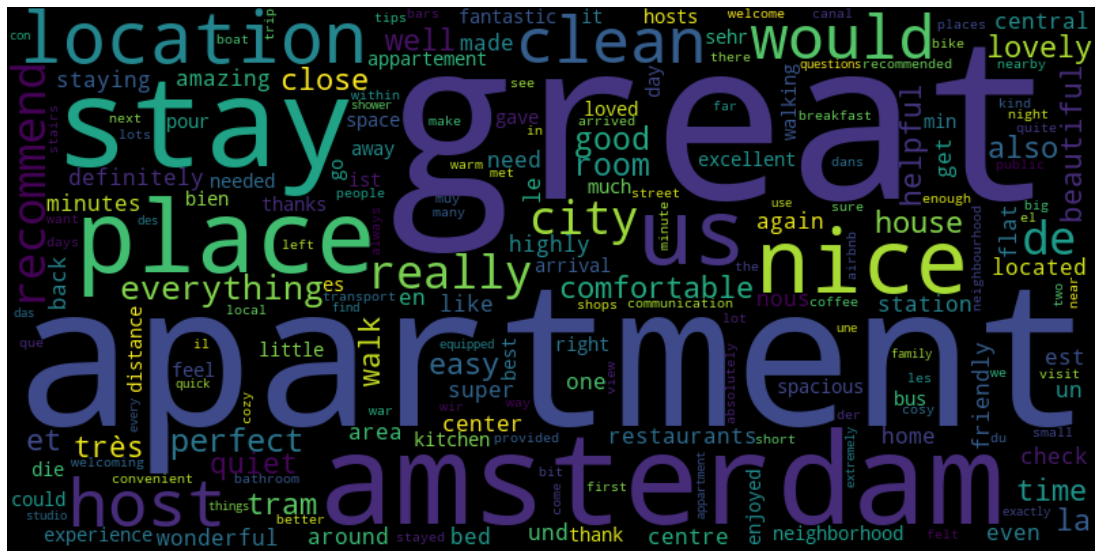

In [96]:
#Creating Word cloud
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

*********Version2***********

In [97]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import cleantext

In [98]:
reviews = pd.read_csv(r'reviews_details.csv')

reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [99]:

#Rename the column in listings from id to listing_id for easier merging
listings = listings.rename({'id' : 'listing_id'}, axis = 1)

df = listings.merge(reviews,
                   how = 'inner',
                   on = 'listing_id')

df.head()

,listing_id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,host_response_rate,street,weekly_price,monthly_price,market,id,date,reviewer_id,reviewer_name,comments
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,...,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,...,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,...,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,...,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,...,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [100]:
df.shape

(431830, 40)

In [101]:
#Checking for null values:

df.isnull().sum()

#There are some null values in the comments section (reviews without comments).
#These should be replaced with empty strings.

df['comments'].fillna(value = '', inplace = True)

#The neighbourhood_group column is entirely null values, so we drop it

#df.drop(labels = 'neighbourhood', axis = 1, inplace = True)

#As for the remaining rows with name and host_name as NA, we drop the entire row since it's only about  ~300 rows in total

df.dropna(axis = 0, inplace = True)

In [102]:
#Check the dataframe after cleaning:

df.isnull().sum()

listing_id                        0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
property_type                     0
accommodates                      0
first_review                      0
review_scores_value               0
review_scores_cleanliness         0
review_scores_location            0
review_scores_accuracy            0
review_scores_communication       0
review_scores_checkin             0
review_scores_rating              0
maximum_nights                    0
listing_url                       0
host_is_superhost           

In [103]:
df['neighbourhood'].unique()

neighbourhood_counts = df.groupby('neighbourhood').count()['listing_id'].sort_values()
neighbourhood_counts

neighbourhood
Gaasperdam - Driemond                        23
Buitenveldert - Zuidas                       48
Geuzenveld - Slotermeer                     241
IJburg - Zeeburgereiland                    456
Noord-Oost                                  505
Noord-West                                  576
Slotervaart                                 591
Watergraafsmeer                             752
Oostelijk Havengebied - Indische Buurt     1744
Oud-Noord                                  1954
Bos en Lommer                              2091
Oud-Oost                                   2092
Westerpark                                 4143
Zuid                                       4164
De Pijp - Rivierenbuurt                    4630
Centrum-Oost                               6857
De Baarsjes - Oud-West                     7923
Centrum-West                              11224
Name: listing_id, dtype: int64

In [104]:

#There are quite a few neighborhoods, so for this analysis we only take the top and bottom 3

neighbourhoods = list(neighbourhood_counts[0:3].index) + list(neighbourhood_counts[-3:len(neighbourhood_counts)].index)

neighbourhoods

['Gaasperdam - Driemond',
 'Buitenveldert - Zuidas',
 'Geuzenveld - Slotermeer',
 'Centrum-Oost',
 'De Baarsjes - Oud-West',
 'Centrum-West']

In [105]:
%%time
GD_comments = df[df['neighbourhood'] == neighbourhoods[1]]['comments'].sum()

Wall time: 4.58 ms


In [106]:
%%time
BO_comments = df[df['neighbourhood'] == neighbourhoods[0]]['comments'].sum()

Wall time: 9.88 ms


In [107]:
%%time
BC_comments = df[df['neighbourhood'] == neighbourhoods[2]]['comments'].sum()

Wall time: 7.91 ms


In [108]:

%%time
CO_comments = df[df['neighbourhood'] == neighbourhoods[3]]['comments'].sum()

#Why does the time taken incrase by so much?

Wall time: 6.72 s


In [109]:
%%time
DBOW_comments = df[df['neighbourhood'] == neighbourhoods[4]]['comments'].sum()


Wall time: 9.84 s


In [110]:
%%time
CW_comments = df[df['neighbourhood'] == neighbourhoods[5]]['comments'].sum()

Wall time: 19.3 s


In [111]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import cleantext

In [112]:

%%time
BO_clean = cleantext.clean(text = BO_comments, extra_spaces = True, punct = True, stopwords = True)
GD_clean = cleantext.clean(text = GD_comments, extra_spaces = True, punct = True, stopwords = True) 
BC_clean = cleantext.clean(text = BC_comments, extra_spaces = True, punct = True, stopwords = True) 
CO_clean = cleantext.clean(text = CO_comments, extra_spaces = True, punct = True, stopwords = True) 
DBOW_clean = cleantext.clean(text = DBOW_comments, extra_spaces = True, punct = True, stopwords = True) 
CW_clean = cleantext.clean(text = CW_comments, extra_spaces = True, punct = True, stopwords = True)

Wall time: 5.9 s


In [113]:
#Lemmatize by reducing each word to the root
import nltk
nltk.download('wordnet')
text_list = [BO_clean, GD_clean, BC_clean, CO_clean, DBOW_clean, CW_clean]

lemmatizer = WordNetLemmatizer()
lemmatized_text_list = [lemmatizer.lemmatize(text) for text in text_list]

[nltk_data] Downloading package wordnet to C:\Users\Diksha
[nltk_data]     Nasa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [114]:

#Create a dictionary with the neighbourhood as keys and the text as values
Neighbourhood_words = dict(zip(neighbourhoods, lemmatized_text_list))

Neighbourhood_words.keys()

dict_keys(['Gaasperdam - Driemond', 'Buitenveldert - Zuidas', 'Geuzenveld - Slotermeer', 'Centrum-Oost', 'De Baarsjes - Oud-West', 'Centrum-West'])

In [115]:
#Check the values are text
Neighbourhood_words['Buitenveldert - Zuidas'][:200]

'We really enjoyed stay Sophias apartment The place located distance 10 minutes away fast train city centre Still close city centre find village surroindings morning wake hearing sounds big citys heavy'

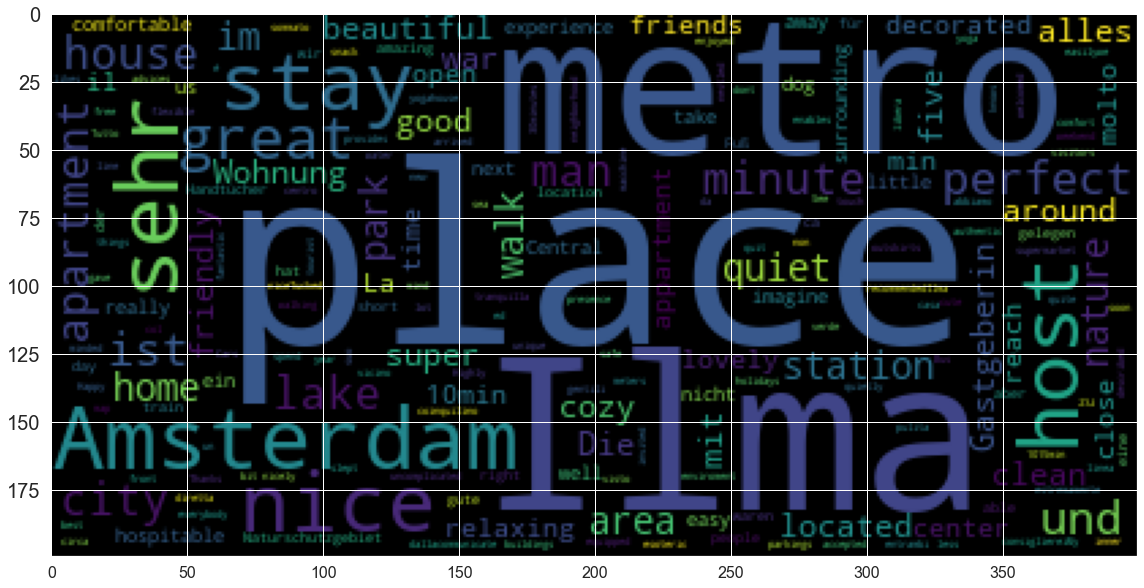

In [116]:
#Wordcloud for gasperdam-driemond
from wordcloud import WordCloud

plt.figure(figsize = (20,10))

wc_BO = WordCloud(background_color = 'black')
wc_BO.generate(Neighbourhood_words['Gaasperdam - Driemond'])

plt.imshow(wc_BO)

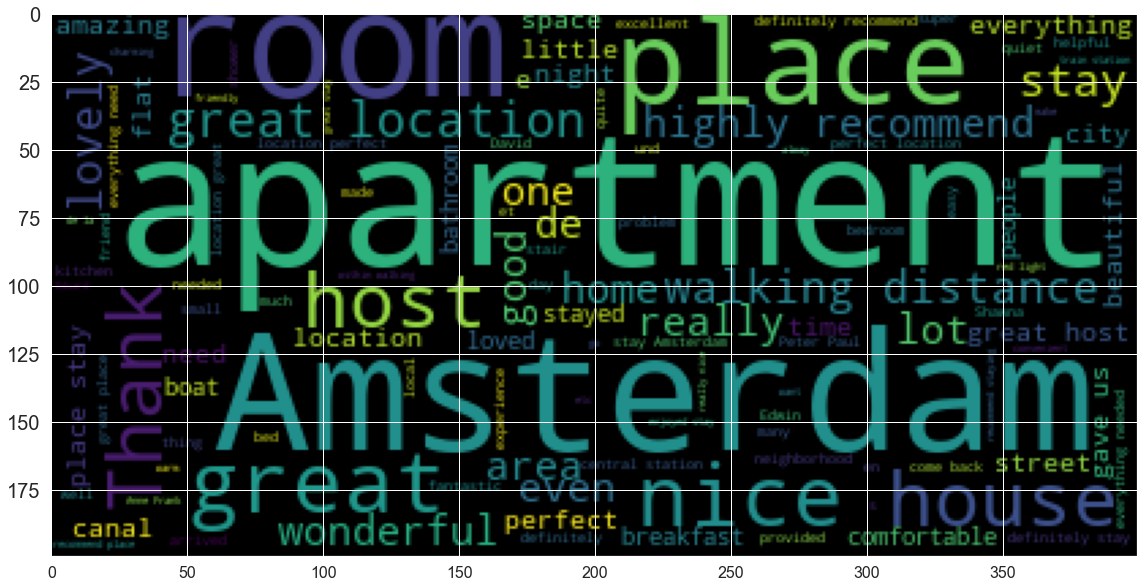

In [117]:
#Wordcloud for Centrum west
wc_CW = WordCloud(background_color = 'black')
wc_CW.generate(Neighbourhood_words['Centrum-West'])

plt.figure(figsize = (20,10))

plt.imshow(wc_CW)

**Recommendation Engine **

In [118]:
neighbourhoods

['Gaasperdam - Driemond',
 'Buitenveldert - Zuidas',
 'Geuzenveld - Slotermeer',
 'Centrum-Oost',
 'De Baarsjes - Oud-West',
 'Centrum-West']

In [119]:
#We only take the busiest 3 and quietest 3 neighbourhoods for our model

df = df[df['neighbourhood'].isin(neighbourhoods)]

In [120]:
#For the word vectors we will use the embeddings done by spacy

import spacy
#!python -m spacy download en_core_web_md

In [121]:

spacymodel = spacy.load('en_core_web_md')

In [122]:
%%time

X = df['comments'].apply(cleantext.clean, punct = True, stopwords = True, extra_spaces = True)

Wall time: 14.2 s


In [123]:
X

523       The apartment spacious clean perfectly located...
524       Excellent accommodation close everything lovel...
525       What I say Flip provided perfect Amsterdam exp...
526       Ottima accoglienza un soggiorno da ripetere Fl...
527       Just superb way spend time Amsterdam A well co...
                                ...                        
424011    Great location easy get everywhere What lovely...
424012    The host canceled reservation 47 days arrival ...
424417    Маленькая чистая и уютная квартира Очень удобн...
424418    Very nice place close Amsterdam Forest great r...
427188    Great houseboat great location great host We r...
Name: comments, Length: 26316, dtype: object

In [124]:
y = df['neighbourhood']

In [125]:
%%time

X_docs = X.apply(spacymodel)

Wall time: 5min 16s


In [126]:
#The model converts it into a doc type

X_docs[523]

The apartment spacious clean perfectly located transport cafes facilities tourist sights The apartment great views fully serviced kitchen suitable cooking meals It lift huge plus Amsterdam The check check easy friendly efficient We met agreed time I would fully recommend apartment would visit next go Amsterdam

In [127]:

type(X_docs[523])

spacy.tokens.doc.Doc

In [128]:
#We can see the review expressed as a word vector:

X_docs[523].vector[:3]

array([ 0.21904188,  0.06621671, -0.1505128 ], dtype=float32)

In [129]:
%%time

#We create a list of the X_train in word vector form:

X_wordvecs = [doc.vector for doc in X_docs]

Wall time: 3.73 s


In [130]:
#Split our data into training and testing data:

from sklearn.model_selection import train_test_split

X_train_wordvecs, X_test_wordvecs, y_train, y_test = train_test_split(X_wordvecs, y, test_size=0.33, random_state=42)

In [131]:
len(y_test)

8685

In [132]:

%%time
#Now we can train a model to classify the reviews based on the mean word vectors

from sklearn.svm import SVC

SVM_classifier = SVC(kernel = 'linear') #Linear kernels work better for classifying text

SVM_classifier.fit(X_train_wordvecs, y_train)

Wall time: 3min 29s


SVC(kernel='linear')

In [133]:

#Saving the model:
import pickle
with open('SVC_model.pkl', 'wb') as file:
    pickle.dump(SVM_classifier, file)

#Load the model:
with open(r'SVC_model.pkl', 'rb') as file:
    SVM_classifier = pickle.load(file)

In [134]:
%%time
#Generate some predictions


predictions = SVM_classifier.predict(X_test_wordvecs)

Wall time: 1min


In [135]:
#Evaluate the model:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [136]:
#Let's evaluate our model to see the accuracy:

accuracy_score(y_test, predictions)

0.5609671848013817

In [137]:

#Get a classification report

print(classification_report(y_test,predictions))

                         precision    recall  f1-score   support

 Buitenveldert - Zuidas       0.00      0.00      0.00        18
           Centrum-Oost       0.57      0.25      0.35      2233
           Centrum-West       0.57      0.77      0.65      3746
 De Baarsjes - Oud-West       0.54      0.54      0.54      2587
  Gaasperdam - Driemond       0.00      0.00      0.00         6
Geuzenveld - Slotermeer       0.91      0.52      0.66        95

               accuracy                           0.56      8685
              macro avg       0.43      0.35      0.37      8685
           weighted avg       0.56      0.56      0.54      8685



C:\Users\Diksha Nasa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [138]:
#See the confusion matrix for the predictions

print(confusion_matrix(y_test,predictions))

[[   0    1    6   11    0    0]
 [   0  561 1148  524    0    0]
 [   0  248 2871  624    0    3]
 [   0  175 1019 1391    0    2]
 [   0    0    3    3    0    0]
 [   0    3   18   25    0   49]]


In [139]:
#Recap the neighbourhoods we're predicting on:
neighbourhoods

['Gaasperdam - Driemond',
 'Buitenveldert - Zuidas',
 'Geuzenveld - Slotermeer',
 'Centrum-Oost',
 'De Baarsjes - Oud-West',
 'Centrum-West']

In [140]:
def recommend(example_review):
    '''
    This function recommends a neighbourhood suitable for your AirBnb stay in Amsterdam.
    The input can be an example review of your preferred place, or some descriptions or keywords of it.
    '''
    import spacy
    
    #First we convert the input into word vectors
    spacymodel = spacy.load('en_core_web_md')
    docs = spacymodel(example_review)
    wordvec = docs.vector
    
    #Import the previously trained model
    with open(r'SVC_model.pkl', 'rb') as file:
        SVC_classifier = pickle.load(file)
    
    
    #Generate the prediction
    prediction = SVC_classifier.predict(np.reshape(wordvec, (-1,300)))
    
    
    print('The recommended neighbourhood for your stay is {}'.format(prediction))

In [141]:
recommend('Farm with animals and plants')

The recommended neighbourhood for your stay is ['De Baarsjes - Oud-West']
